In [253]:
from contextlib import nullcontext
import os

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

gamma = 1.4
cells_x = 200
cells_y = 200
xmin, xmax = -1, 1
ymin, ymax = -1, 1
xrange = np.linspace(xmin, xmax, num=cells_x, endpoint=False)
yrange = np.linspace(ymin, ymax, num=cells_y, endpoint=False)
grid = np.array([np.array([[x, y] for y in yrange]) for x in xrange])
dx = (xmax - xmin) / cells_x
dy = (ymax - ymin) / cells_y
dt = 0.001

In [208]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [229]:
# energy
def E(rho, p, u, v):
    return (p / (gamma - 1)) + (0.5 * rho * (u ** 2 + v ** 2))

# pressure
def P(rho, u, v, E):
    return (gamma - 1) * (E - (0.5 * rho * (u ** 2 + v ** 2)))

# convert from cartesian (x, y) to polar coordinates (r, theta)
def cartesian_to_polar(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    return (r, theta)

# convert from polar (r, theta) to cartesian coordinates (x, y)
def polar_to_cartesian(r, theta):
    return (r * np.cos(theta), r * np.sin(theta))

HLL Riemann Solver Approximation

In [241]:
def c_s(gamma, P, rho):
    return np.sqrt(gamma * P / rho)

# returns (lambda_plus, lambda_minus)
def lambdas(U, x=True):
    v_x, v_y = U[1] / U[0], U[2] / U[0]
    rho, E = U[0], U[-1]
    cs = c_s(gamma, P(rho, v_x, v_y, E), rho)
    
    v = v_x if x else v_y
    return (v + cs, v - cs)

# returns (alpha_p, alpha_m)
def alphas(U_L, U_R, x=True):
    lambda_L = lambdas(U_L, x=x)
    lambda_R = lambdas(U_R, x=x)
    alpha_p = max(0, lambda_L[0], lambda_R[0])
    alpha_m = max(0, -lambda_L[1], -lambda_R[1])

    return (alpha_p, alpha_m)

def F_HLL(F_L, F_R, U_L, U_R):
    a_p, a_m = alphas(U_L, U_R, x=True)
    return (a_p * F_L + a_m * F_R - (a_p * a_m * (U_R - U_L))) / (a_p + a_m)

def G_HLL(G_L, G_R, U_L, U_R):
    a_p, a_m = alphas(U_L, U_R, x=False)
    return (a_p * G_L + a_m * G_R - (a_p * a_m * (U_R - U_L))) / (a_p + a_m)

def L(F_L, F_R, G_L, G_R):
    return -((F_R - F_L) / dx) - ((G_R - G_L) / dy)

def HLL(U, F, G, S):
    L_ = np.zeros((cells_x, cells_y, 4))
    
    # compute HLL flux at each interface
    for i in range(len(U)):
        for j in range(len(U[i])):
            F_L = F_HLL(F[i-1 if i > 0 else 0][j], F[i][j], 
                        U[i - 1 if i > 0 else 0][j], U[i][j])
            F_R = F_HLL(F[i][j], F[i + 1 if i < len(U) - 1 else len(U) - 1][j], 
                        U[i][j], U[i + 1 if i < len(U) - 1 else len(U) - 1][j])
            
            G_L = G_HLL(G[i][j - 1 if j > 0 else 0], G[i][j], 
                        U[i][j - 1 if j > 0 else 0], U[i][j])
            G_R = G_HLL(G[i][j], G[i][j + 1 if j < len(U[i]) - 1 else len(U[i]) - 1], 
                        U[i][j], U[i][j + 1 if j < len(U[i]) - 1 else len(U[i]) - 1])

            # compute semi discrete L (including source term)
            L_[i][j] = L(F_L, F_R, G_L, G_R)

    if S is not None:
        return np.add(L_, S(U))
    else:
        return L_

In [236]:
def update_flux(U, F, G):
    for i in range(len(U)):
        for j in range(len(U[i])):
            _u = U[i][j]
            rho, u, v, E = _u[0], _u[1] / _u[0], _u[2] / _u[0], _u[3]
            p = P(rho, u, v, E)
            F[i][j] = np.array([rho * u, rho * (u ** 2) + p, rho * u * v, (E + p) * u])
            G[i][j] = np.array([rho * v, rho * u * v, rho * (v ** 2) + p, (E + p) * v]) # why is order different for G compared to F?

def first_order_step(U, F, G, S):
    L = HLL(U, F, G, S)
    return np.add(U, L * dt)

In [242]:
def plot_U(U, t=0, var="density"):
    rho = U[:, :, 0] # extract density value at each cell
    u = U[:, :, 1] / rho
    v = U[:, :, 2] / rho
    E = U[:, :, 3]
    p = P(rho, u, v, E)

    if var == "density":
        c = plt.imshow(np.transpose(rho), cmap="plasma", interpolation ='nearest', origin ='lower', extent=[xmin, xmax, ymin, ymax])
    elif var == "pressure":
        c = plt.imshow(np.transpose(p), cmap="plasma", interpolation ='nearest', origin ='lower', extent=[xmin, xmax, ymin, ymax])

    plt.colorbar(c)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(var)

def run_simulation(U, T, S=None, filename=None, var="density", plot=plot_U):
    # flux in x: F = (rho * u, rho * u^2 + P, rho * u * v, (E + P) * u)
    F = np.zeros((cells_x, cells_y, 4))
    # flux in y: G = (rho * v, rho * u * v, rho * v^2 + P, (E + P) * v)
    G = np.zeros((cells_x, cells_y, 4))

    t = 0.0
    plot(U, t, var=var)
    plt.show()
    fig = plt.figure()
    fps, dur = 12, 8
    iters = T / dt
    n = math.floor(iters / (dur * fps)) if iters > (dur * fps) else 1
    if filename:
        # output video writer
        clear_frames = True
        FFMpegWriter = animation.writers['ffmpeg']
        metadata = dict(title=filename, artist='Leo Betancourt', comment='')
        writer = FFMpegWriter(fps=fps, metadata=metadata)
        PATH = f"./{filename}"
        if not os.path.exists(PATH):
            os.makedirs(PATH)
        cm = writer.saving(fig, f"./{filename}/{var}.mp4", 100)
    else:
        cm = nullcontext()  

    with cm:
        printProgressBar(0, T / dt, prefix = "Progress:", suffix = "Complete", length=50)
        while t < T:
            update_flux(U, F, G)
            U = first_order_step(U, F, G, S)
            if filename and ((t // dt) % n == 0):
                if clear_frames:
                    fig.clear()
                plot(U, t, var=var)
                writer.grab_frame()
            
            t += dt
            printProgressBar(t / dt, T / dt, prefix = "Progress:", suffix = "Complete", length=50)

    fig.clear()
    plot(U, t, var=var)
    plt.show()

In [ ]:
# Sedov-Taylor blast

# plot spherically symmetric blast in 1d
def plot_blast(U, t, var=None):
    rho = U[:, :, 0] # extract density value at each cell
    u = U[:, :, 1] / rho
    v = U[:, :, 2] / rho
    E = U[:, :, 3]
    p = P(rho, u, v, E)

    r, theta = cartesian_to_polar(grid[:, :, 0], grid[:, :, 1])
    r_bins = np.linspace(0, np.max(r), num=200)
    bin_indices = np.digitize(r, bins=r_bins)
    avg_rho, avg_E = np.zeros(len(r_bins)), np.zeros(len(r_bins))
    for i in range(1, len(r_bins)):
        mask = bin_indices == i
        if np.any(mask):
            avg_rho[i - 1] = np.mean(rho[mask])
            avg_E[i - 1] = np.mean(E[mask])

    R = np.power(np.divide(np.multiply(avg_E, t ** 2), 1), 1/5)
    dim_free = np.divide(r_bins, R, out=np.zeros_like(r_bins), where=R!=0)
    plt.plot(dim_free[avg_rho != 0], avg_rho[avg_rho != 0], color="red")
    plt.xlim(0, 10)
    plt.xlabel(r"$\frac{r}{R}$")
    plt.ylabel("rho")

U = np.zeros((cells_x, cells_y, 4))
# get polar coordinates of each cell in the grid
r, theta = cartesian_to_polar(grid[:, :, 0], grid[:, :, 1])
U[r < 0.1] = np.array([1, 0, 0, 10])
U[r >= 0.1] = np.array([1, 0, 0, E(1, 1e-4, 0, 0)])

run_simulation(U, T=0.1, filename="sedov_blast_2d", plot=plot_blast)

In [ ]:
# implosion
U = np.zeros((cells_x, cells_y, 4))
# get polar coordinates of each cell in the grid
r, theta = cartesian_to_polar(grid[:, :, 0], grid[:, :, 1])
U[r < 0.2] = np.array([0.125, 0, 0, E(0.125, 0.14, 0, 0)])
U[r >= 0.2] = np.array([1, 0, 0, E(1, 1, 0, 0)])

run_simulation(U, T=0.01, filename="implosion_2d", var="pressure")

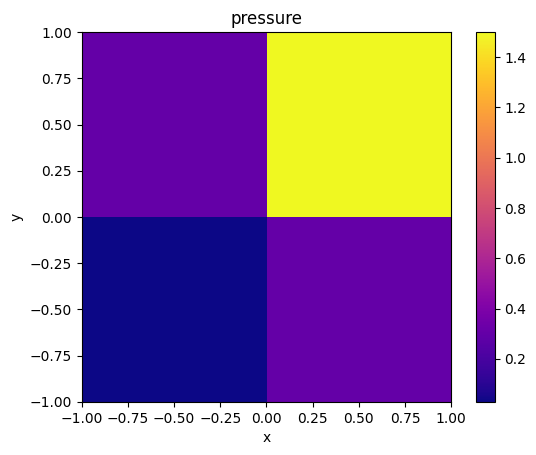

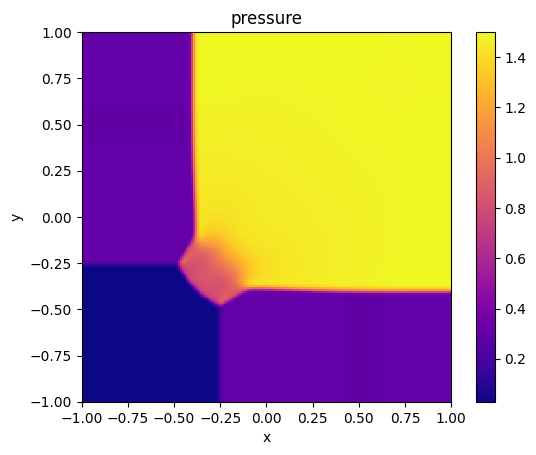

In [254]:
# case 3 in Liska Wendroff (four quadrants)
U = np.zeros((cells_x, cells_y, 4))
x, y = grid[:, :, 0], grid[:, :, 1]
# initial conditions of four quadrants
rho_1, u_1, v_1, p_1 = 0.5323, 1.206, 0, 0.3
rho_2, u_2, v_2, p_2 = 1.5, 0, 0, 1.5
rho_3, u_3, v_3, p_3 = 0.138, 1.206, 1.206, 0.029
rho_4, u_4, v_4, p_4 = 0.5323, 0, 1.206, 0.3
U[(x < 0) & (y >= 0)] = np.array([rho_1, rho_1 * u_1, rho_1 * v_1, E(rho_1, p_1, u_1, v_1)])
U[(x >= 0) & (y >= 0)] = np.array([rho_2, rho_2 * u_2, rho_2 * v_2, E(rho_2, p_2, u_2, v_2)])
U[(x < 0) & (y < 0)] = np.array([rho_3, rho_3 * u_3, rho_3 * v_3, E(rho_3, p_3, u_3, v_3)])
U[(x >= 0) & (y < 0)] = np.array([rho_4, rho_4 * u_4, rho_4 * v_4, E(rho_4, p_4, u_4, v_4)])

run_simulation(U, T=0.6, filename="quadrants_2d", var="pressure")

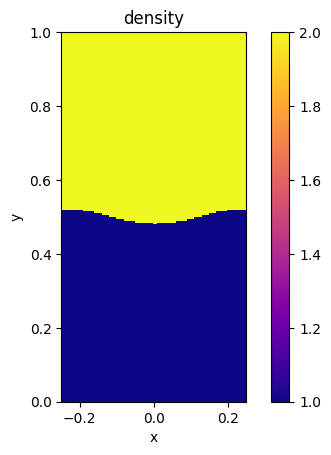

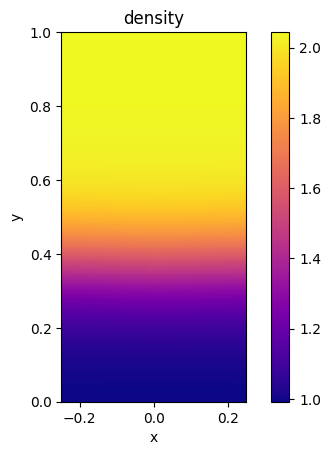

In [232]:
# rayleigh-taylor instability
cells_x = 50
cells_y = 200
xmin, xmax = -0.25, 0.25
ymin, ymax = 0, 1
xrange = np.linspace(xmin, xmax, num=cells_x, endpoint=False)
yrange = np.linspace(ymin, ymax, num=cells_y, endpoint=False)
grid = np.array([np.array([[x, y] for y in yrange]) for x in xrange])
dx = (xmax - xmin) / cells_x
dy = (ymax - ymin) / cells_y
dt = 0.001

U = np.zeros((cells_x, cells_y, 4))
g = -0.1


def y_pert(x):
    return (0.5 - 0.02 * np.cos(4 * np.pi * x))

for i in range(len(grid)):
    for j in range(len(grid[i])):
        x = grid[i][j][0]
        y = grid[i][j][1]

        if y >= y_pert(x):
            p = 2.5 + g * 2 * (y - 0.5)
            U[i][j] = np.array([2, 0, 0, E(2, p, 0, 0)])
        else:
            p = 2.5 + g * 1 * (y - 0.5)
            U[i][j] = np.array([1, 0, 0, E(1, p, 0, 0)])

# source term (gravity)
def source(U):
    S = np.zeros((cells_x, cells_y, 4))
    rho = U[:, :, 0]
    u = U[:, :, 1] / rho
    v = U[:, :, 2] / rho
    S[:, :, 0] = np.zeros_like(rho)
    S[:, :, 1] = np.zeros_like(rho)
    S[:, :, 2] = g * rho
    S[:, :, 3] = g * np.multiply(rho, v)
    return S

run_simulation(U, T=2, S=source, filename=None, var="density")